# В этом файле мы восстанавливаем 3d координаты из 2d с помощью уравнения плоскости

In [1]:
import numpy as np
import cv2, PIL, os
from cv2 import aruco
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
%matplotlib nbagg

### Достанем результат калибровки:

In [2]:
def get_info_calibrate_camera():
    """
    Возвращает информацию, необходимую для исключения искажений с изображений
    """
    import pickle
    f = open("data_of_calibrate_camera.pckl", "rb")
    ret = pickle.load(f)
    mtx = pickle.load(f)
    dist = pickle.load(f)
    rvecs = pickle.load(f)
    tvecs = pickle.load(f)
    return ret, mtx, dist, rvecs, tvecs

ret, mtx, dist, rvecs, tvecs = get_info_calibrate_camera()

### Вытащим картинку для калибровки + undistord её

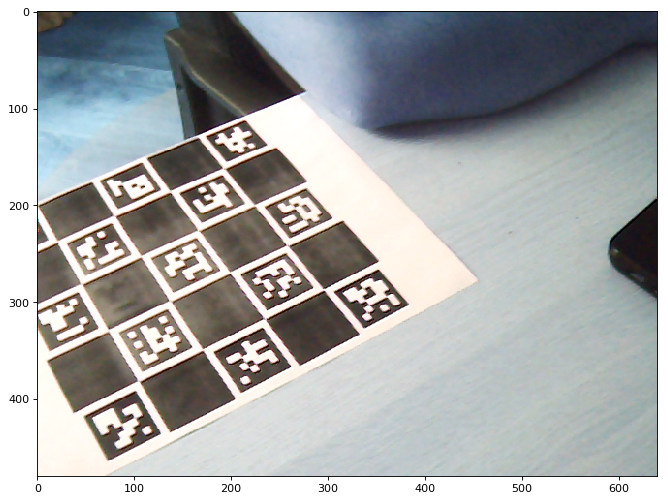

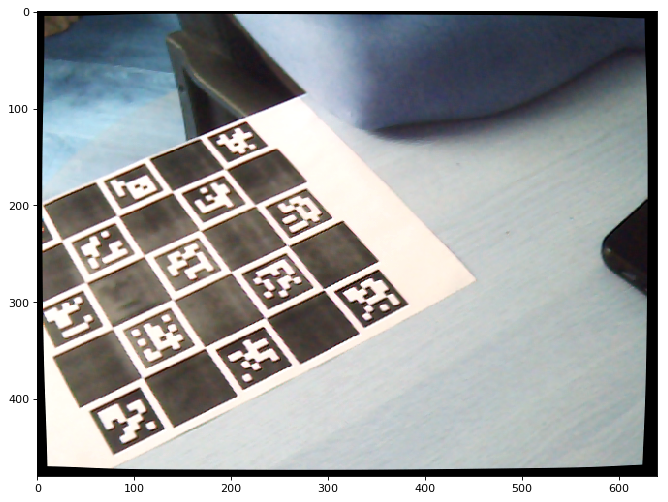

In [3]:
def get_undistorted_image(path, mtx, dist):
    """
    Достаем из path картинку и сразу убираем искажения
    """
    frame = cv2.imread('./../data/test_coordinates/real_coordinates.png')
    #print(os.getcwd())
    #print(frame)
    plt.figure(figsize=(10, 8), dpi=80)
    plt.imshow(frame, interpolation = "nearest")
    frame = cv2.undistort(src = frame, cameraMatrix = mtx, distCoeffs = dist)
    plt.figure(figsize=(10, 8), dpi=80)
    plt.imshow(frame, interpolation = "nearest")
    plt.show()
    return frame

frame = get_undistorted_image('./../data/test_coordinates/real_coordinates.png', mtx, dist)

In [4]:

gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
aruco_dict = aruco.Dictionary_get(aruco.DICT_6X6_250)
parameters =  aruco.DetectorParameters_create()
corners, ids, rejectedImgPoints = aruco.detectMarkers(gray, aruco_dict, 
                                                      parameters=parameters)
# SUB PIXEL DETECTION
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.0001)
for corner in corners:
    cv2.cornerSubPix(gray, corner, winSize = (3,3), zeroZone = (-1,-1), criteria = criteria)
    
frame_markers = aruco.drawDetectedMarkers(frame.copy(), corners, ids)

#corners

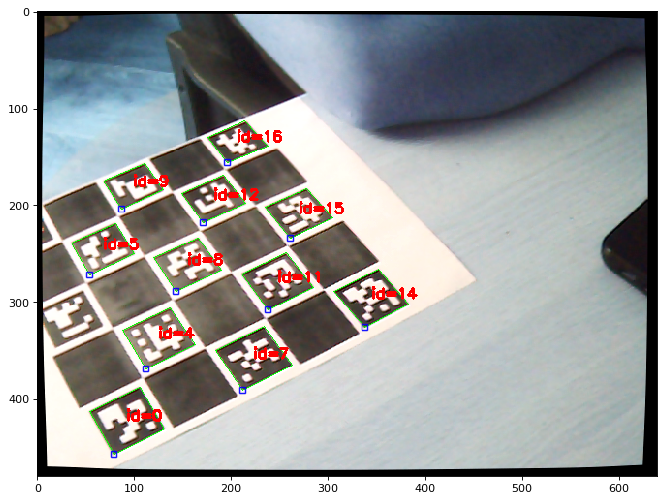

In [5]:
plt.figure(figsize=(10, 8), dpi=80)
plt.imshow(frame_markers, interpolation = "nearest")

plt.show()

### Получим информацию о маркерах с калибровочной доски для задания плоскости

In [6]:
size_of_marker =  0.0285 # side lenght of the marker in meter
rvecs,tvecs,_objPoints  = aruco.estimatePoseSingleMarkers(corners, size_of_marker , mtx, dist)
print(tvecs)

[[[ 0.00922013  0.02342506  0.37863069]]

 [[-0.07658817 -0.07369071  0.4679236 ]]

 [[-0.12091797  0.08791677  0.38489434]]

 [[-0.05191442  0.05342847  0.3713561 ]]

 [[-0.10770751  0.0459721   0.39705221]]

 [[-0.04194685  0.01477436  0.38933712]]

 [[-0.09654319  0.00571684  0.41531465]]

 [[-0.15357569 -0.00374991  0.4395323 ]]

 [[-0.03209491 -0.02378617  0.41089377]]

 [[-0.08576757 -0.03378969  0.43695894]]

 [[-0.14192018 -0.04413054  0.46149366]]]


In [7]:
print(ids.flatten())

[14 16  0  7  4 11  8  5 15 12  9]


In [8]:
data = pd.DataFrame(data = tvecs.reshape(len(tvecs),3), columns = ["tx", "ty", "tz"], 
                    index = ids.flatten())
data.index.name = "marker"
data.sort_index(inplace= True)
data
#print(data.loc[0:1].values[0])

,tx,ty,tz
marker,,,
0,-0.120918,0.087917,0.384894
4,-0.107708,0.045972,0.397052
5,-0.153576,-0.003750,0.439532
7,-0.051914,0.053428,0.371356
8,-0.096543,0.005717,0.415315
9,-0.141920,-0.044131,0.461494
11,-0.041947,0.014774,0.389337
12,-0.085768,-0.033790,0.436959
14,0.009220,0.023425,0.378631


## Получим уравнение плоскости
#### (тут надо переписать, чтобы не выбирать точки на одной прямой)
https://ege-ok.ru/2012/03/18/uravnenie-ploskosti

In [9]:
def get_plane_equation(tvecs):
    """
    Тут мы получаем уравнение плоскости из заданных 3d координат tvecs
    Этот участок кода зависит от того, какую ArucoBoard мы используем. Сейчас он написан для board.png
    """
    mat_plane_solve = [None]*len(tvecs-2)
    mat_plane_solve = np.array(mat_plane_solve)
    mat_plane_end = [0.]*3 #говнокод, но работает
    mat_plane_end = np.array(mat_plane_end) # среднее значение коэфф уравнения плоскости
    
    for i in range(len(tvecs)-2):
        if (i != 5 and i!=8): #выкинули неверные уравнения, тк точки на одной прямой
            mat_plane_a = np.array([tvecs[i][0],tvecs[i+1][0],tvecs[i+2][0]])
            mat_plane_b = np.array([[-1],[-1],[-1]])
            mat_plane_solve[i] = np.linalg.solve(mat_plane_a,mat_plane_b)
            #print("i = ", i)
            #print(mat_plane_solve[i])
            for j in range(3):
                mat_plane_end[j] += float(mat_plane_solve[i][j][0])/(len(tvecs)-2)
                #print(float(mat_plane_solve[i][j][0])/float(mat_plane_solve[i][0][0]))
        #print(mat_plane_solve)
    return mat_plane_end

In [10]:
mat_plane_end = get_plane_equation(tvecs)
print(mat_plane_end) # среднее значение коэфф уравнения плоскости

[-0.79373893 -1.18618008 -2.03176126]


## Далее получим 2d координаты точки из 3d:

In [11]:
def get_2D_from_3D(x_3d):
    """
    Функция переводит 3D координаты в 2D координаты пикселей на экране
    i = номер выбранной точки 
    """
    x_3d =np.array([[tvecs[i][0][0]],[tvecs[i][0][1]],[tvecs[i][0][2]]])
    #print(x_3d) # - 3d координаты
    x_2d = np.matmul(mtx,x_3d) # Ненормализованный вектор 2d координат
    #print(x_2d) 
    
    #Нормализуем x_2d
    x_2d = list(x_2d)
    x0 = x_2d[0]/x_2d[2]
    y0 = x_2d[1]/x_2d[2]
    
    return np.array([x0,y0])








# Я тут остановился 22.09.19








In [16]:
i = 0 #выбираем точку 
x_3d =np.array([[tvecs[i][0][0]],[tvecs[i][0][1]],[tvecs[i][0][2]]])
x = get_2D_from_3D(x_3d)

i = 1 #выбираем точку 
x_3d1 =np.array([[tvecs[i][0][0]],[tvecs[i][0][1]],[tvecs[i][0][2]]])
x1 = get_2D_from_3D(x_3d1)

print(x)

[[207.21743434]
 [135.01647636]]


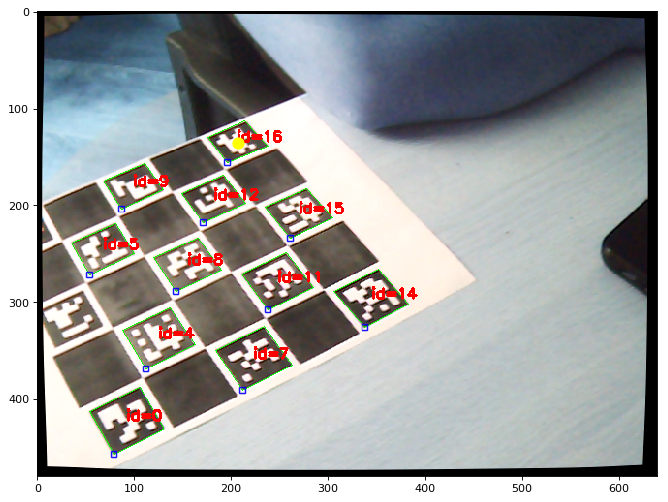

In [13]:
def plot_point_on_frame(frame_markers, x):
    """
    Рисует картинку с желтыми точками в координатах x[0],x[1]
    """
    plt.figure(figsize=(10, 8), dpi=80)
    plt.imshow(frame_markers, interpolation = "nearest")
    for i in range(len(x[0])):
        plt.scatter(x[0], x[1], s=100,color = 'yellow') # рисуем точку в месте полученных координат, и она у нас соглась с исходной!
    plt.show()

plot_point_on_frame(frame_markers,x)

## Попытаемся теперь наоборот, получить 3d координаты из 2d

In [18]:
x1_2d = np.array([x[0],x[1],[1]])
print(x1_2d)

[[207.21743434]
 [135.01647636]
 [  1.        ]]


In [19]:
invmtx = np.linalg.inv(mtx)
print(invmtx)

[[ 0.00136907  0.         -0.44737219]
 [ 0.          0.00136907 -0.34233174]
 [ 0.          0.          1.        ]]


In [20]:
x1_3d = np.matmul(invmtx,x1_2d) # Сырые, неподогнанные координаты
print(x1_3d)
print()
print(x_3d) # Настоящие координаты

[[-0.16367666]
 [-0.1574845 ]
 [ 1.        ]]

[[-0.07658817]
 [-0.07369071]
 [ 0.4679236 ]]


In [21]:
x2_3d = np.full((3,1),0.)
for i in range(3):
    x2_3d[i][0] = float(x_3d[i][0])/float(x1_3d[i][0])
print(x2_3d)#Проверим, а не множителя ли нам не хватает?

[[0.4679236]
 [0.4679236]
 [0.4679236]]


### Ура! Нам осталось подогнать множитель для координат, используя уравнение плоскости

In [22]:
print(mat_plane_end) # коэффициенты уравнения плоскости
print()
m = -1/(np.matmul(mat_plane_end,x1_3d))
print(m)


[-0.79373893 -1.18618008 -2.03176126]

[0.58307687]


In [23]:
x_end_3d = x1_3d*m # c учетом подгона того факта, что точка на плоскости
print(x_end_3d)
print()
print(x_3d)

[[-0.09543607]
 [-0.09182557]
 [ 0.58307687]]

[[-0.07658817]
 [-0.07369071]
 [ 0.4679236 ]]


### Оценим погрешность результата:

In [24]:
x_dev_3d = 0
for i in range(3):
    x_dev_3d += ((float(x_3d[i][0])-float(x_end_3d[i][0]))*x_3d[i][0])**2
x_dev_3d = x_dev_3d**0.5*100
print(x_dev_3d,"%")

5.391882913697806 %


#### Наша погрешность получилась < 6% для всех точек Имхо, более чем норм (подозрение на низкое качество калибровки)